In [13]:
# Importar librerías
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal


def crear_gaussiana(X, Y, x0, y0, intensidad, sigma=5):
    """
    Crea una función gaussiana bidimensional.

    Parameters:
    X (ndarray): Coordenadas X de la cuadrícula.
    Y (ndarray): Coordenadas Y de la cuadrícula.
    x0 (float): Coordenada X del centro de la gaussiana.
    y0 (float): Coordenada Y del centro de la gaussiana.
    intensidad (float): Amplitud de la gaussiana.
    sigma (float): Desviación estándar de la gaussiana.

    Returns:
    ndarray: Valores de la función gaussiana en la cuadrícula especificada.
    """
    return intensidad * np.exp(-0.5 * (((X - x0) ** 2 + (Y - y0) ** 2) / sigma**2))

def generar_imagen_gaussiana(sampled_points, image_shape, sigma):
    """
    Genera una imagen usando Gaussian Splatting.

    Parameters:
    sampled_points (list of tuples): Lista de puntos muestreados (x, y, intensidad).
    image_shape (tuple): Dimensiones de la imagen (alto, ancho).

    Returns:
    ndarray: Imagen generada con Gaussian Splatting.
    """
    # Crear una rejilla 2D donde calcular las gaussianas
    x = np.linspace(0, image_shape[1], image_shape[1])
    y = np.linspace(0, image_shape[0], image_shape[0])
    X, Y = np.meshgrid(x, y)

    # Inicializar la imagen generada con gaussianas
    gaussian_image = np.zeros(image_shape, dtype=np.float64)

    # Generar la imagen con gaussian splatting
    for point in sampled_points:
        x0, y0, intensidad = point
        gaussian = crear_gaussiana(X, Y, x0, y0, intensidad, sigma)
        gaussian_image += gaussian

    # Normalizar la imagen generada
    gaussian_image /= np.max(gaussian_image)
    return gaussian_image


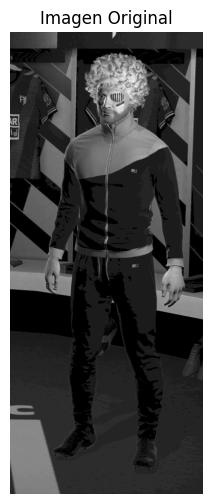

In [14]:
# Leer la imagen usando OpenCV
image_path = "assets/persona.png" 
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Verificar que la imagen se haya leído correctamente
if image is None:
    raise ValueError("No se pudo cargar la imagen. Verifica la ruta.")

# Mostrar la imagen original
plt.figure(figsize=(6, 6))
plt.title("Imagen Original")
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.show()



# Reducir el tamaño de la imagen para facilitar el muestreo
downsample_factor = 1
image_downsampled = cv2.resize(image, (image.shape[1] // downsample_factor, image.shape[0] // downsample_factor))


### Muestreo basado en decimar la imagen

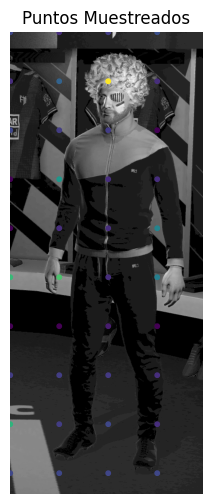

In [15]:
# Generar puntos equidistantes (muestreo)
step = 100  # Distancia entre puntos
sampled_points = []

for y in range(0, image_downsampled.shape[0], step):
    for x in range(0, image_downsampled.shape[1], step):
        intensity = image_downsampled[y, x] / 255.0  # Normalizar intensidad entre 0 y 1
        sampled_points.append((x, y, intensity))

# Convertir los puntos a un arreglo numpy para facilitar operaciones
sampled_points = np.array(sampled_points)

# Mostrar puntos muestreados en la imagen
plt.figure(figsize=(6, 6))
plt.title("Puntos Muestreados")
plt.imshow(image_downsampled, cmap="gray")
plt.scatter(sampled_points[:, 0], sampled_points[:, 1], c=sampled_points[:, 2], cmap="viridis", s=10)
plt.axis("off")
plt.show()


In [ ]:
# Generar la imagen usando la función
gaussian_image = generar_imagen_gaussiana(sampled_points, image_downsampled.shape, 100)

# Mostrar la imagen generada
plt.figure(figsize=(6, 6))
plt.title("Imagen Generada con Gaussian Splatting")
plt.imshow(gaussian_image, cmap="viridis")
plt.axis("off")
plt.show()


### Muestreo basado en bordes

In [17]:
from skimage.filters import sobel

# Detectar bordes usando Sobel
edges = sobel(image_downsampled)

# Seleccionar puntos donde el gradiente es mayor que un umbral
threshold = 0.1  # Ajusta este valor según el nivel de detalle deseado
edge_points = np.argwhere(edges > threshold)

# Muestrear puntos equitativamente entre los bordes detectados
sampled_points = []
step = 5  # Ajusta la densidad del muestreo
for i in range(0, len(edge_points), step):
    y, x = edge_points[i]
    intensity = image_downsampled[y, x] / 255.0
    sampled_points.append((x, y, intensity))

sampled_points = np.array(sampled_points)


In [18]:
# Generar la imagen usando la función
gaussian_image = generar_imagen_gaussiana(sampled_points, image_downsampled.shape)

# Mostrar la imagen generada
plt.figure(figsize=(6, 6))
plt.title("Imagen Generada con Gaussian Splatting")
plt.imshow(gaussian_image, cmap="viridis")
plt.axis("off")
plt.show()

TypeError: generar_imagen_gaussiana() missing 1 required positional argument: 'sigma'